## Intro to deep learning for medical imaging, by [MD.ai](https://www.md.ai)

## Lesson 3. Pneumonia detection

The MD.ai annotator is used to view the DICOM images, and to create the image level annotation. The MD.ai python client library is then used to download images and annotations, prepare the datasets, then are then used to train the model for classification. 

- Original Dataset URL: 
- MD.ai annotator project URL: https://public.md.ai/annotator/project/
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai/

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [1]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath('.')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

%matplotlib inline 

### Requirement: Install Matterport's Mask-RCNN implementation for object detection and instance segmentation 

- See matterport's implementation of Mask-RCNN and **installation** instructions on [github].(https://github.com/matterport/Mask_RCNN)

In [ ]:
sys.path.append(os.path.abspath('../Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [3]:
!pip install --upgrade --quiet --no-cache mdai

import mdai

import mdai
mdai.__version__

'0.0.4'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [ ]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `XXXX` for `https://public.md.ai/annotator/project/XXXX`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [ ]:
p = mdai_client.project('Y2qr3Bvn', path='./lesson3-data')

## Prepare data

In [ ]:
p.show_label_groups()

### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [20]:
# this maps label ids to class ids
# labels L_o8w and L_yd0 are both background classes, and their class ids are both 0 
# label L_v8n is the lung opacity class, class id is 1 

labels_dict = {'L_o8w':0, # background 
               'L_yd0':0, # background  
               'L_v8n':1, # lung opacity 
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_o8w': 0, 'L_yd0': 0, 'L_v8n': 1}


In [21]:
p.show_datasets()
dataset = p.get_dataset_by_id('D_e57')
dataset.prepare()

Datasets:
Id: D_e57, Name: Dataset



In [ ]:
dataset.show_classes()

In [26]:
anns = dataset.get_annotations()

### Create the *Training* and *Validation* datasets

In [10]:
# dataset split 
train_dataset, valid_dataset = mdai.common_utils.train_test_split(dataset)

Num of instances for training set: 26715, validation set: 2969


In [31]:
anns = dataset.get_annotations(labels_dict.keys(), verbose=True)

Dataset contains 33968 annotations, filtered by label ids dict_keys(['L_o8w', 'L_yd0', 'L_v8n']).


### Mask-RCNN Config

see [https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py)

In [12]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16 # on aws, use 16
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05
    LEARNING_RATE = 0.0005
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANC

### Mask-RCNN Dataset

see [https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py)

In [13]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, source_name, dataset, orig_height, orig_width):
        super().__init__(self)
        
        # add classes 
        for k, v in dataset.classes_dict.items():
            if v['class_id'] is not 0: 
                self.add_class(source_name, v['class_id'], v['class_text'])

        # add images 
        img_ids = dataset.get_image_ids()
        imgs_anns_dict = dataset.imgs_anns_dict
        
        for i, fp in enumerate(img_ids):
            annotations = imgs_anns_dict[fp]
            self.add_image(source_name, image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(
            fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            assert(dataset.label_id_to_class_id(a['labelId']) == 0)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['data'] is not None:
                    x = int(a['data']['x'])
                    y = int(a['data']['y'])
                    w = int(a['data']['width'])
                    h = int(a['data']['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = dataset.label_id_to_class_id(a['labelId'])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [14]:
# Training dataset
source_name = 'pneumonia'
dataset_train = DetectorDataset(source_name, train_dataset, 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(source_name, valid_dataset, 1024, 1024)
dataset_val.prepare()

### Display a few images

[1 1 1]


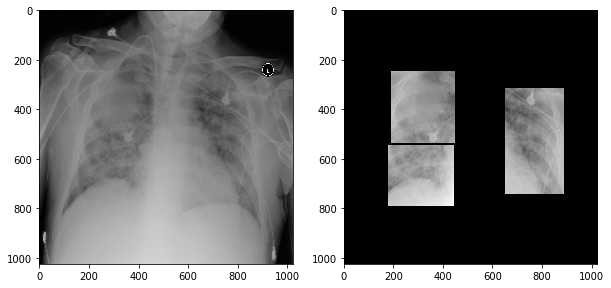

In [16]:
# Load and display random samples
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')

### Training

In [17]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [18]:
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [19]:
WEIGHTS_DIR = os.path.abspath('../weights')
model_path = os.path.join(WEIGHTS_DIR,'mask_rcnn_pneumonia_0040.h5' )

if not os.path.exists(model_path): 
    raise Exception('Weights {} not found!'.format(model_path))

## Model was previously trained on the cloud, loading pre-trained model insteading 

In [22]:
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='all',
            augmentation=augmentation)

In [30]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/tian/mdai-git/rsna-pneumonia/weights/mask_rcnn_pneumonia_0040.h5


In [31]:
model.config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

### Evaluate model on few random images

In [32]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [47]:
def show_randoms(dataset):
    fig = plt.figure(figsize=(10,20))

    num_imgs = 3 
    for i in range(num_imgs):

        image_id = random.choice(dataset.image_ids)
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, 
                                   image_id, use_mini_mask=False)
     
        plt.subplot(num_imgs, 2, 2*i + 1)
        visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                    dataset.class_names,
                                    colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
        plt.title('Ground Truth')
        
        plt.subplot(num_imgs, 2, 2*i + 2)
        
        # turn off verbose if you don't want debug messages 
        results = model.detect([original_image],verbose=1)
        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], 
                                    colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
        plt.title('Prediction')

In [48]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

/home/tian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32


/home/tian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32


/home/tian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



*** No instances to display *** 

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32

*** No instances to display *** 



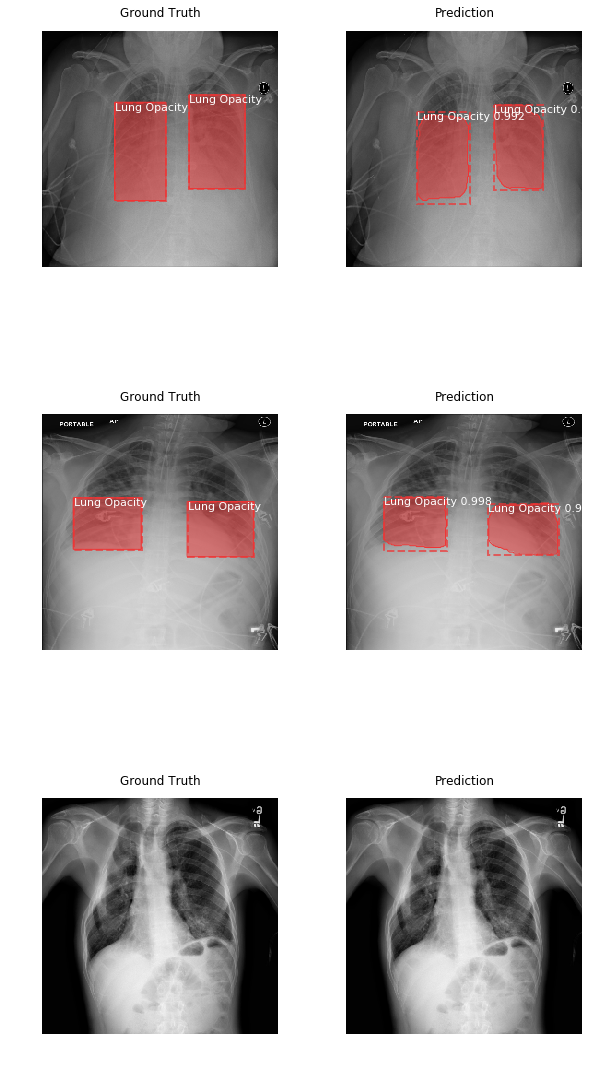

In [49]:
show_randoms(dataset_val)